In [ ]:
import autorootcwd
from src.model.model import FrozenInTime, compute_similarity
from src.data.data_loader import TextVideoDataLoader
import torch.optim as optim
import torch
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_loader = TextVideoDataLoader(
    dataset_name= "NTU",
    text_params= {"input": "text",},
    video_params= {"input_res": 224, "num_frames": 4,},
    data_dir= "data/nturgbd",
    metadata_dir= "data/nturgbd",
    split= 'test',
    tsfm_params= None,
    tsfm_split= None,
    cut= None,
    subsample= 1,
    sliding_window_stride= -1,
    reader= 'decord',
    batch_size=1,
    num_workers=1,
    shuffle=True,
)

c:\Users\user\Documents\Fine-VLA\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\Documents\Fine-VLA\.venv\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
model = FrozenInTime(
    video_params={"model": "SpaceTimeTransformer", "num_frames": 4, "arch_config":"base_patch16_224", "vit_init": "imagenet-21k", "attention_style":"frozen-in-time", "pretrained":True},
    text_params={"model": "distilbert-base-uncased", "pretrained": True},
    projection_dim=256,
)

model.to(device)

######USING ATTENTION STYLE:  frozen-in-time


FrozenInTime(
  (text_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

In [4]:
batch = next(iter(data_loader))

print(batch.keys)
print("video tensor:", batch['video'].shape)
print("text list:", batch['text'])
print("meta keys:", batch['meta'].keys())

<built-in method keys of dict object at 0x0000025D336E7EC0>
video tensor: torch.Size([1, 4, 3, 224, 224])
text list: ['writing']
meta keys: dict_keys(['raw_captions', 'paths', 'dataset'])


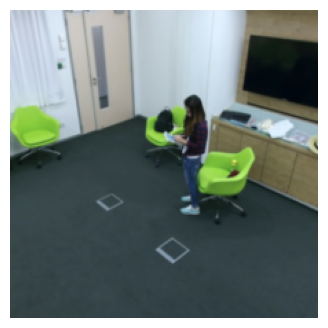

In [5]:
video_data = batch['video'].to(device)
video_example = video_data[0, 0]
video_example = video_example.permute(1, 2, 0).cpu().numpy()
""" frame이 [C, H, W] = [3, 224, 224]인데 permute(1,2,0)은 차원 순서를 바꿔 [H, W, C] = [224, 224, 3]로 만듬
    이유는 matplotlib 같은 라이브러리에 이미지를 넘길 때는 (height, width, channels) 형태가 필요하기 때문
"""

plt.figure(figsize=(4,4))
plt.imshow((video_example - video_example.min()) / (video_example.max()-video_example.min()))
plt.axis('off')
plt.show()

In [6]:
video_embedding = model.compute_video(video_data)
print(video_embedding)

tensor([[-1.5344e+00,  3.0188e-01,  4.1111e-01, -6.8447e-01, -1.9076e+00,
          8.6180e-02, -1.8740e-01,  2.2261e-01, -1.2373e-02, -2.4317e+00,
          1.5210e-01,  6.0622e-01,  1.1432e+00, -1.1679e+00, -2.0257e-01,
         -1.4732e+00, -2.1592e-01, -7.5955e-01,  4.6756e-01, -1.5600e+00,
         -2.0870e+00, -1.7780e+00, -9.3063e-01,  1.5839e-01, -1.7745e-01,
         -1.4557e+00,  2.4555e+00, -3.0720e-01,  2.1598e-01, -4.1798e-01,
          4.6735e-02,  1.1985e-01,  1.5773e-01, -4.3984e-01,  8.1858e-01,
          2.0154e+00,  3.0560e-01,  2.0622e+00,  4.9301e-01,  1.8037e-01,
         -2.9615e-01, -8.4911e-01, -4.3183e-01, -9.8062e-01, -3.9949e-01,
          7.0111e-01,  6.5893e-01,  6.7246e-01, -3.3102e-02, -2.2011e+00,
         -1.6121e+00, -1.4671e+00, -5.0545e-01,  5.5138e-01,  2.6467e-01,
         -1.3788e+00, -8.1426e-02,  1.2112e+00,  1.9483e+00, -1.0272e+00,
         -1.6964e+00,  6.1325e-02, -1.0703e+00, -7.7362e-02,  1.3124e+00,
          2.2592e+00, -8.0128e-01, -3.

In [7]:
model = FrozenInTime(
    video_params={"model": "VJEPA2", "num_frames": 32, "arch_config":"base_patch16_224","pretrained":True},
    text_params={"model": "distilbert-base-uncased", "pretrained": True},
    projection_dim=256,
)

model.to(device)

FrozenInTime(
  (text_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

In [8]:
video_embedding = model.compute_video(video_data)
print(video_embedding)

tensor([[ 0.0577, -0.9227, -1.4782,  0.8341,  0.3624, -0.8640,  0.4589, -2.2705,
         -0.1201,  1.1431, -1.3952,  0.2540, -0.1162,  1.7566, -0.9966,  2.5126,
         -0.1862, -0.3296, -0.5372, -0.4776,  1.0608, -0.6802,  0.8078,  0.2405,
         -0.2733,  0.4337, -0.5960, -1.8631, -0.4554,  0.8577,  0.3201,  1.0058,
          1.3543, -0.3878, -0.0906,  1.1566,  1.5386,  1.3075,  0.3360, -0.0867,
         -0.2388,  1.7131,  0.3403,  0.7241, -1.6134, -1.4166,  1.8652, -0.3906,
          1.6745,  0.0089, -0.5237, -0.0216, -0.5073, -1.8745,  0.2333, -0.1585,
         -0.1600,  0.2174, -0.8112, -0.2700,  0.3252,  0.6970,  1.3802,  0.2930,
          0.0143,  0.5003,  0.4485, -1.3837, -1.5487, -1.0149,  0.8273, -0.9536,
         -1.1412, -0.9145, -0.7039, -1.2797, -0.9728, -2.1728, -1.8532,  0.4719,
         -0.8252, -1.6950, -0.5871, -0.2641,  0.7058,  0.2957,  2.3506, -0.5888,
         -0.9434, -0.2806,  0.1588,  1.3621, -0.5269,  0.6470,  0.1497, -0.3884,
          0.1110, -0.1022, -

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

print(batch['text'][0])

text_data = tokenizer(
    batch['text'],
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=tokenizer.model_max_length
).to(device)

tear_up_paper


In [9]:
print(text_data.keys())
print(text_data['input_ids'].shape)
print(text_data['attention_mask'].shape)
print(text_data['input_ids'][0])
print(text_data['attention_mask'][0])

ids = text_data['input_ids'][0]
decoded = tokenizer.decode(ids, skip_special_tokens=True)
print(f"[{0}] decoded:", decoded)
print(f"     raw   :", batch['text'][0])

KeysView({'input_ids': tensor([[ 101, 7697, 1035, 2039, 1035, 3259,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])})
torch.Size([1, 7])
torch.Size([1, 7])
tensor([ 101, 7697, 1035, 2039, 1035, 3259,  102])
tensor([1, 1, 1, 1, 1, 1, 1])
[0] decoded: tear _ up _ paper
     raw   : tear_up_paper


In [10]:
text_embedding = model.compute_text(text_data)
print(text_embedding)

tensor([[ 1.4122e-01, -3.1683e-02, -9.2303e-02, -1.1754e-01,  1.4015e-01,
         -4.5835e-02, -9.7897e-03, -8.2788e-02,  1.3657e-01,  8.1463e-02,
          5.9255e-02, -4.0265e-03, -4.3239e-02, -4.1053e-02, -7.8171e-02,
          1.0050e-01,  3.4276e-02, -1.2842e-01, -2.3943e-01,  5.1434e-03,
         -3.8621e-02, -3.0953e-02,  1.6767e-02, -1.7729e-02,  1.2329e-01,
         -2.5486e-02,  3.4158e-02,  1.5291e-01,  7.0181e-02,  1.1113e-01,
          7.5028e-02,  3.1457e-02,  4.2484e-02, -3.2157e-02,  4.6965e-03,
         -2.7692e-01, -5.3492e-02,  4.8729e-02,  3.6163e-02,  1.2093e-03,
          1.4026e-01,  1.3527e-03,  1.2316e-01, -1.0068e-01,  9.7450e-02,
         -5.8156e-02,  7.9134e-02,  1.1494e-01,  3.5048e-03, -5.0133e-02,
         -1.0916e-01, -8.0881e-02,  3.2526e-01, -9.9981e-02, -2.3519e-02,
         -2.8529e-01, -2.3917e-02, -1.9883e-02, -7.4645e-02,  8.5404e-02,
         -2.6336e-01, -2.7449e-02, -1.8658e-02, -2.3441e-01,  1.4032e-02,
          9.0417e-02, -6.2571e-02, -9.

In [11]:
sim_matrix, _ = compute_similarity(text_embedding, video_embedding)

print(sim_matrix)

tensor([[0.1001]], grad_fn=<MmBackward0>)
